# Pattern matching


We will start in the same way as the last notebook started  - by downloading/importing the packages needed and importing the .csv file(s) needed. In this case, we only need the .csv file that has the matched abstracts as we are specifically looking at person-first and identity-first patterns that are "about" autism (or ASD, Asperger's syndrome, etc.). 

We could use the same basic approach to look at person-first and identity-first language for other conditions for which there are good noun and adjective forms of the words (diabetes? obesity? cancer? something else?). Doing that would mean using the .csv file with all of the abstracts or potentially creating and entirely new file of abstracts matched to another condition of interest. However, that lies outside the scope of this research, so I will not address it further here. 

## Get ready 

As always, we start with code that:
* loads up and nicknames some useful packages, 
* checks file locations,
* imports files, and 
* checks them. 


In [1]:
%%capture

!pip install nltk
!pip install spacy -q
!python -m spacy download en_core_web_lg -q

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics

import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math
import matplotlib.pyplot as plt
print(os.listdir("..\\output")  )    

# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output.

## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import the specific file of interest for this step of the analysis.

In [2]:
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
len(matched_texts)                                                                # check the length 

4600

## Cleaning phase

Cleaning begins by turning any instances of extra whitespaces (two or more in a row) into a single whitespace. Then, identifying any run-on sentences (where a lowercase letter, a full stop, and an uppercase letter are clustered without a whitespace) and inserting a whitespace between the full stop and the uppercase letter. Both of these steps will improve the sentence tokenisation that happens next. 

Then, we proceed to sentence tokenising the text. Like word tokens, sentence tokens become the unit for analysisis. As a trivial example, sentence tokenisation would turn a short text such as 


''' The cat named Cat is one of five cats. Honestly, I wonder why I have so many cats.
''' 

into a list of sentence tokens like

''' [[The cat named Cat is one of five cats.]

[Honestly, I wonder why I have so many cats.]]

''' 

An important difference is that the punctuation within the sentences that contributes to its structured and meaning (e.g. the comma and the full stops) are retained. This punctuation, like the capitalisation at the start of the sentences or for the poper nouns, is also retained as it helps the sentence-tokenisation process identify the words within the sentence correctly for their parts of speech (e.g. which of the words are nouns, verbs, etc. ). 



The sentence tokens are then put on individual rows, filtered to retain only those that contain one or more of the keywords of interest, and then filtered to ensure that there are no empty rows or duplicates. 

In [3]:
def remove_errors (input):
    no_extra_spaces = re.sub(r'(\s)(\s+)', r'\1', input)               # turn 2+ sequential whitespaces into 1
    no_run_ons1 = re.sub(r'([a-z].)([A-Z])', r'\1 \2', no_extra_spaces) # identifies run-ons (e.g. "word.New sentence ")
    no_run_ons2 = re.sub(r'([A-Z].)([A-Z])', r'\1. \2', no_run_ons1) # identifies run-ons (e.g. "ACRONYM.New sentence ")

    return(no_run_ons2)

In [4]:
no_run_ons = [remove_errors(abstract) for abstract in matched_texts['Text'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_texts['Sentence'] = no_run_ons       # copy the no extra space/run-on abstract list back into df as a new column

In [5]:
sentences  = [sent_tokenize(abstract) for abstract in matched_texts['Text'] ] # create tokenised list of cleaner abstracts
matched_texts['Sentence'] = sentences                                   # copy that list back into df as a new column
sentence_per_row = matched_texts.explode('Sentence')                    # explode column in new df with 1 row/sentence token
print("How many sentences in total: " + str(len(sentence_per_row)))     # check the length of new df


How many sentences in total: 84671


In [6]:
print(sentence_per_row[['Text','Sentence']])                            # have a look. The selected rows should have 
                                                                        # 'Text' the same, but 'Sentence' different 

                                                                                                                                                                                                         Text  \
0      'Music of Life' a new metaphor for genomics, delivered as Facilitating understanding of whole genome sequencing in film within genetic counselling young people A. Middleton1,J. Borra2, T. Pope3,V...   
0      'Music of Life' a new metaphor for genomics, delivered as Facilitating understanding of whole genome sequencing in film within genetic counselling young people A. Middleton1,J. Borra2, T. Pope3,V...   
0      'Music of Life' a new metaphor for genomics, delivered as Facilitating understanding of whole genome sequencing in film within genetic counselling young people A. Middleton1,J. Borra2, T. Pope3,V...   
0      'Music of Life' a new metaphor for genomics, delivered as Facilitating understanding of whole genome sequencing in film within genetic counselling young peop

In [7]:
matched_sentences = sentence_per_row[sentence_per_row['Sentence'].str.contains('[Aa]utis|ASD|AS|[Aa]sperger')]
                                                     # create a new data frame with only the sentences that contain keywords
print("How many matching sentences: " + str(len(matched_sentences)))            # check the length

How many matching sentences: 9776


In [8]:
matched_sentences = matched_sentences[~matched_sentences['Sentence'].isnull()]  # remove any rows with empty 'Sentence' column
matched_sentences = matched_sentences.drop_duplicates()                         # drop any duplicates
print("Now how many matching sentences: " + str(len(matched_sentences)))        # check length of remaining data frame

Now how many matching sentences: 9775


In working with the matching sentences, it became clear there were several common errors, variations on how things were written and other annoying minor differences in the texts that made the manual checking more time-consuming than it needed to be.

Further, the minor differences meant that the counting steps later on were counting "child with ASD" separately from "child with autism" when perhaps the more interesting distinction there is whether "child with autism/ASD" is more or less common than "patient with autism/ASD" or "proband with autism/ASD" or any other common person-nouns. 

Thus, this tidy_up_terminology function corrects several importing errors, spelling and style differences, and consolidates on terminology. 

In [9]:
def tidy_up_terminology (input):
    space1 = re.sub(r'([A-Z]).(A-Z)', r'\1. \2', input)                 # removes multiple white spaces between words
    space2 = re.sub(r'([a-z])(disorder|disability|spectrum)', r'\1 \2', space1) # adds a space in select run-ons
    space3 = re.sub(r'([a-z])(disorder|spectrum)', r'\1 \2', space2)    # a second go at adding a space in select run-ons      
    space4 = re.sub(r'(spec) (trum)', r'\1\2', space3)                  # removes a space between 'spec' and 'trum'
    no_apost = re.sub(r'([Aa]sperger[\S*?]s)', r'asperger', space4)     # lowercases, removes ' and S from '[Aa]sperger's' 
    lower1 = re.sub(r'Autis', r'autis', no_apost)                       # lowercases 'Autism' and 'Autistic'
    lower2 = re.sub(r'[Aa]spergers|[Aa]sperger', r'asperger', lower1)   # lowercases/removes S from '[Aa]spergers' & '[Aa]sperger'
    lower3 = re.sub(r'[Ss]pectrums|[Ss]pectra', r'spectrum', lower2)    # lowercases and removes various plurals for spectrum
    lower4 = re.sub(r'[Ss]yndromes|[Ss]yndrome', r'syndrome', lower3)   # lowercases and removes plurals for syndrome
    lower5 = re.sub(r'[Dd]isorders|Disorder', r'disorder', lower4)      # lowercases and removes plurals for disorder
    lower6 = re.sub(r'[Dd]iseases|Disease', r'disease', lower5)         # lowercases and removes plurals for disease
    plur = re.sub(r'ASDs', r'ASD', lower6)                              # removes plural from instances of more than one ASD
    stan0 = re.sub(r'(autism|autistic|asperger) syndrome', r'autism spectrum', plur ) # turns select 'syndrome' to 'spectrum'
    stan1 = re.sub(r'spectrum disease', r'spectrum disorder', stan0 )   # turns select 'disease' to 'disorder'
    stan2 = re.sub(r'(autism|autistic|asperger) spectrum disorder \(ASD\)', r'ASD', stan1) # abbreviates various ASD definitions
    stan3 = re.sub(r'(autism|autistic|asperger) spectrum disorder', r'ASD', stan2) # abbreviates various options to ASD
    stan4 = re.sub(r'(autism|autistic|asperger) spectrum \(AS\)', r'ASD', stan3)  # standardises more options to ASD
    stan5 = re.sub(r'(autism|autistic|asperger) spectrum', r'ASD', stan4)         # standardises more options to ASD
    stan6 = re.sub(r'AS ', r'ASD ', stan5)                              # standardises 'AS ' to 'ASD ' - note trailing space
    stan7 = re.sub(r'(autism|autistic|asperger) disorder', r'ASD', stan6) # abbreviates various ASD definitions
    aut0 = re.sub(r'asperger autism', r'autism', stan7)                  # standardises 'asperger autism' to 'autism'
    ID1 = re.sub(r'[Ii]ntellectual [Dd]isability \(ID\)', r'ID', aut0)
    ID2 = re.sub(r'[Ii]ntellectual [Dd]isability', r'ID', ID1)

    return(ID2)

In [10]:
 # Optional cell code block to test or understand what the tidy_up_terminology function does
    
tidy_test = "Autism spectrum intellectual disability and autism ID, ASD \
            Autisticspectrum autisticspectrumdisorder ASD \
            Asperger's syndrome asperger's syndrome \
            intellectual disability Intellectual Disability (ID)\
            aspergers syndrome autism spectrum  ASDs ASD ID, and autism "

tidy_up_terminology(tidy_test)

'ASD ID and autism ID, ASD            ASD ASD ASD            ASD ASD            ID ID           ASD ASD  ASD ASD ID, and autism '

In [11]:
tidy_text = [tidy_up_terminology(sentence) for sentence in matched_sentences['Sentence'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_sentences['Sentence'] = tidy_text    # copy the no extra space/run-on abstract list back into df as a new column

In [12]:
backup = matched_sentences                    # A backup is useful at this step because the next may not go the way you expect

In [13]:
matched_sentences = backup                    # If you need the backup, re-run this step. 

## Extraction

Following the cleaning phase, we move on to the extraction phase. This has two parts, first for the person-first extraction and then for the identity-first extraction. 

The results of both extractions are saved in their own column to make it easy to read and also to allow for a single sentence-token to contain both kinds of patterns. 

### Person-first pattern

In [14]:
pattern_1 = [{"POS": "NOUN"},                                        # define the person-first pattern - start with a noun
             {'DEP':'amod', 'OP':"?"},                               # followed by an optional modifier
             {"TEXT": {"REGEX": "(with|by|from)"}},                  # followed by some words that set up the p-f pattern
             {'DEP':'amod', 'OP':"?"},                               # then space for up to three optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS$)"}}] # finally, the keywords (original format, just in case)

# Matcher class object 
matcher = Matcher(nlp.vocab)                                         # define a matcher class object
matcher.add("matching_1", [pattern_1])                               # add my three person-first patterns to it


In [15]:
def find_pattern_match(input):                                               # define a function that applies the person-first
    thingy = nlp(input)                                                      # matcher class object to strings
    match = matcher(thingy)                                                  # and returns any matches to the pattern(s)
    if match == []:
        out_value = ''
    else:
        hold_multi_spans = []
        for match_id, start, end in match:
                string_id = nlp.vocab.strings[match_id]  # Get string representation
                span = thingy[start:end]  # The matched span
                hold_multi_spans.append(span)
        out_value = hold_multi_spans
    return out_value

In [16]:
matched_sentences['Person-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly defined person-first matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # double check length remains same

9775

### Identity-first pattern

In [17]:
pattern_a = [{'DEP':'amod', 'OP':"?"},                                 # same for identity-first patterns,
             {'DEP':'amod', 'OP':"?"},                                 # starting with two optional modifiers
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS$)"}}, # the keywords (original format, just in case)
             {'DEP':'amod', 'OP':"?"},                                 # then upt to three more optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]                                          # and then a noun

# Matcher class object                                         
matcher = Matcher(nlp.vocab) 
matcher.add("matching_2", [pattern_a])            # this overwrites the matcher object to identity-first

In [18]:
matched_sentences['Identity-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly overwritten matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # check the length - why not?

9775

### Consolidation

Following the cleaning and extraction phases, the last phase is consolidation. This phase further refines the data by removing all the rows that do not contain a match for one or both of the patterns. For example, there would be a row for "The child was tested for autism." because it contains a keyword of interest. However, this sentence would be eliminated in the consolidation phase as the keyword does not fit into either the person-first or identity-first patterns. 

Further, this phase goes on to lemmatise the extracted patterns so that they can be counted more easily. This phase also lowercases all occurrences of "Autistic", "Autism", and "Asperger's" as well as removing the apostrophe, the 's' and any non-white characters that might intrude between the 'r' and the 's' of "Asperger's". This phase also removes any square brackets, quotes and extra commas introduced by the lemmatisation process. 

This phase ends by writing out the consolidated data frame to a .csv for manual inspection. I could not find a feasible way of identifying whether or not the nouns matched in the extraction phase are person-nouns or not. As the list is not a totally unreasonable length (in the hundreds) I found it workable to 
* open in excel, 
* save the file under another name (e.g. pattern_matches_reviewed), 
* order the entire data set alphabetically by 'Person-first', 
* scan through the ordered results check whether each result in the 'Person-first' column is about a person, 
* removing entire rows if the 'Person-first' match is not about a person (checking the 'Sentence' or 'Text' column if needed)
* re-order the entire data set alphabetically by 'Identity-first', 
* scan through the ordered results check whether each result in the 'Identity-first' column is about a person, 
* removing entire rows if the 'Identity-first' match is not about a person, 
* save file again. 

For example, 'association with autism' matches the person-first pattern but is not about a person, so this row was removed. Many more rows were removed in the 'Identity-first' matches as things like 'autistic behaviours' and 'autism testing' were removed for not being about people. 

NOTE: There were several instances of "ASD dataset" which are not easy to determine if they are about people or not. Do they mean dataset composed from blood tests taken as part of ASD testing? If so, each row in the data set would be a blood test with the possibility that more than one test comes from the same person. Or do they mean a pool of case records, each of which represents a single person? The former would not be "about people" but the second would. I did not remove these rows as we cannot be certain. Leaving them out would also have been a valid option, as long as the choice was clear. 

Coincidentally, during this manual checking part of the consolidation phase I learned that, in the context of human genetics research "proband" is a person-noun. 

In [19]:
matched_patterns = matched_sentences[(matched_sentences['Person-first'] != '') | (matched_sentences['Identity-first'] != '')]
                                                     # keep only rows w/ non-null 'Person-first' and/or 'Identity-first' columns
len(matched_patterns)                                # check length

1141

In [20]:
matched_patterns = matched_patterns.explode('Person-first')    # explode 'Person-first' column to create 1 row per match
                                                               # if there were two matches within the same sentence
len(matched_patterns)                                          # check the length

1145

In [21]:
matched_patterns = matched_patterns.explode('Identity-first')  # Do the same for 'Identity-first' column
len(matched_patterns)                                          # check the length

1324

In [22]:
matched_patterns                                               # have a look at them

,Unnamed: 0,Title,Session_Code,Author,Affiliations,Text,Year,Authors_and_Affiliations,Email,Sentence,Person-first,Identity-first
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications.,"(boys, with, autism)",
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,We report the analysis of13 candidate gene loci associated with autism and schizophrenia in 17Finnish ASD families with autosomal dominant mode of inheritance.,,"(ASD, families)"
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish ASD families.,,"(Finnish, ASD, families)"
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish ASD families.,,"(ASD, families)"
28,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,NaN,NaN,Prader Willi (PWS) and Angelman AS) syndrome are multigenic disordercharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expression...,2001.0,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,malliend@uec.inta.uchile.cl,Approximately 70% of PWSand ASD patients have a deletion in 15q11 q13 whereas uniparental disomy(UPD) accounts for 25% of PWS cases and 2 3% of AS.,,"(ASD, patients)"
...,...,...,...,...,...,...,...,...,...,...,...,...
4554,675,NaN,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a familial translocation or inversion. but not at other stages...,2004.0,NaN,NaN,and the PWS/ASD region on 15q11-13.,,"(ASD, region)"
4554,675,NaN,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a fami

In [23]:
Lem = WordNetLemmatizer()                         # Define a short way to call the WordNetLemmatizer

def consolidate_matched_patterns (input):         # 
    final_lemma_list = []
    temp_lemma_list = []
    for phrase in input:                       # start for loop looking at each pattern in the person-first pattern column
        phrase_as_string = str(phrase)                               # hold the current pattern
        words_in_phrase = phrase_as_string.split() # split the current pattern into words
        for word in words_in_phrase :                            # for each word in the split up words
            lemma = Lem.lemmatize(word)             # turn that word into a lemma
            temp_lemma_list.append(lemma)                # append that lemma to a temporary list
        string_lem = str(temp_lemma_list)              # turn that temporary list into a string
        stripped_lem = re.sub(r"\[|\]|\'|\,",'', string_lem)  # remove  square brackets, commas and '' marks from the string
        final_lemma_list.append(stripped_lem)        # append the string version of the list to the output list
        temp_lemma_list = []                               # ensure the temp variable is empty

    return(final_lemma_list)


In [24]:
person_lemma_list = consolidate_matched_patterns(matched_patterns['Person-first'])
identity_lemma_list = consolidate_matched_patterns(matched_patterns['Identity-first'])

In [25]:
matched_patterns['Person-first'] = person_lemma_list    # copy the person-first output to new column in data frame 
matched_patterns['Identity-first'] = identity_lemma_list  # copy the identity-first output to new column in data frame 
matched_patterns = matched_patterns.drop_duplicates()                         # drop any duplicates
matched_patterns                                                   # have a look at the data frame with its new columns

,Unnamed: 0,Title,Session_Code,Author,Affiliations,Text,Year,Authors_and_Affiliations,Email,Sentence,Person-first,Identity-first
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications.,boy with autism,
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,We report the analysis of13 candidate gene loci associated with autism and schizophrenia in 17Finnish ASD families with autosomal dominant mode of inheritance.,,ASD family
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish ASD families.,,Finnish ASD family
15,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autism whose clinical features resembled autism with some modifications. Itis characteri...,2001.0,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,irma.jarvela@hus.fi,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish ASD families.,,ASD family
28,400,Prader Willi and Angelman Syndromes in Chilean Patients. Clinical and Molecular Diagnosis.,P0295.,NaN,NaN,Prader Willi (PWS) and Angelman AS) syndrome are multigenic disordercharacterized by developmental and neurobehavioral abnormalities. Dif ferent underlying genetic defects cause loss of expression...,2001.0,Curotto L. Santa Mar a A. Alliende F. Cort s INTA University of Chile SANTIAGO C,malliend@uec.inta.uchile.cl,Approximately 70% of PWSand ASD patients have a deletion in 15q11 q13 whereas uniparental disomy(UPD) accounts for 25% of PWS cases and 2 3% of AS.,,ASD patient
...,...,...,...,...,...,...,...,...,...,...,...,...
4554,675,NaN,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a familial translocation or inversion. but not at other stages...,2004.0,NaN,NaN,and the PWS/ASD region on 15q11-13.,,ASD region
4554,675,NaN,NaN,NaN,NaN,P0280Two cases of Cri Du Chat syndrome in the same family Spatial association of oppositely imprinted regions in late S-phase without a familial translocation or inversion. but not

In [26]:
matched_patterns.to_csv('..\\output\\pattern_matches_to_review.csv')        
                                                            # Write the data frame to a .csv for manual processing in excel

At this point, I open the file in Excel (for example), removed the brackets, quotation marks and commas in the Person-first lemmatised and Identity-first lemmatised columns, then sort by each of one of these columns. I then scan through the results, removing any rows that are obviously not about people (e.g. "autistic testing") and checking the 'Text' column on any that are unclear 'autistic quartets'). I then sort by the other column and repeat the step of reviewing and deleting non-person rows. Save under "pattern_matches_reviewed.csv" for the next step. 

## Exlporing statistics for person-first and identity-first

In [67]:
reviewed_matches = pd.read_csv('..\\output\\pattern_matches_reviewed.csv')    # one for just those that match the keyword
reviewed_matches.head(3)

,Unnamed: 0.1,Unnamed: 0,Title,Session_Code,Author,Affiliations,Text,Year,Authors_and_Affiliations,Email,Sentence,Person-first,Identity-first
0,141,23,The search for autism susceptibility genes,S11.,"Monaco1, IMGSAC2, SLIC3","1Wellcome Trust Centre for Human Genetics, University of Oxford, Oxford, United Kingdom, 2The International Molecular Genetic Study of Autism Consortium (http://www.well.ox.ac.uk/~maestrin/iat.h...","autism is characterised by impaired social interaction and communication, and is accompanied by repetitive and stereotyped behaviours and interests. autism has an onset in the first three years, ...",2002,NaN,NaN,83 sibling pairs families with autism were screened for linkage using a whole genome scan and areas of increased allele sharing were genotyped with 119 markers in a further 69 sibling pair families.,family with autism,NaN
1,1179,36,De Novo Mutations in Neurodevelopmental disorders,S10.3,"G. A. Rouleau, J. Michaud","Centre of Excellence in Neurosciences of UniversitÃÂ© de MontrÃÂ©al, Centre Hospitalier de lÃ¢ÂÂUniversitÃÂ© de MontrÃÂ©al, Faculty of Medicine, UniversitÃÂ© of MontrÃÂ©al, Montreal, QC, C...","INTRODUCTION: Schizophrenia (SCZ), autism and intellectual deficiency (ID) are common, devastating and poorly treated neurodevelopmental brain disorder. The wide spectrum of symptoms and clinical ...",2012,NaN,NaN,"In order to test this hypo thesis we first sequenced over 400 synaptic genes in 148 subjects with SCZ, 148 subjects with ASD and 96 subjects with ID.",subject with ASD,NaN
2,2594,22,A highly conserved program of neuronal microexons is misregulated in autistic brains,S06.2,"M. Irimia, M. Quesnel Vallieres, N. Parikshak, D. H. Geschwind, S. P . Cordes, B. J. Blencowe","Centre for Genomic Regulation (CRG), Barcelona, Spain, University of Toronto, Toronto, ON, Canada, University of California Los Angeles, Los Angeles, CA, United States, Lunenfeld Tanenbaum Resea...",A key challenge in understanding autism is to establish whether this gene tically heterogeneous disorder is caused by common mechanisms. Tran scriptomic profiling has revealed consistently altered...,2016,NaN,NaN,"These include a program of 3 27 nucleotide Ã¢ÂÂmicroexonsÃ¢ÂÂ, which is misregulated in the brains of individuals with autism.",individual with autism,NaN


In [68]:
print("There are " + 
      str(len(reviewed_matches)) + " rows in the post-manual review data frame coming from " +
      str(reviewed_matches['Title'].nunique()) +
      " unique titles.")

There are 635 rows in the post-manual review data frame coming from 298 unique titles.


In [69]:
def find_PF_nouns(input):
    output = []
    for thingy in input:
        if isinstance(thingy,str):
            word_list = thingy.split()
            noun = word_list[0]
            output.append(noun)
        else:
            output.append("")
    return output

def find_IF_nouns(input):
    output = []
    for thingy in input:
        if isinstance(thingy,str):
            word_list = thingy.split()
            noun = word_list[-1]
            output.append(noun)
        else:
            output.append("")
    return output

In [70]:
reviewed_matches['PF_nouns'] = find_PF_nouns(reviewed_matches['Person-first'])

In [71]:
print("In total, there are " + str(reviewed_matches['Person-first'].count()) +
      " examples of PFL, coming from " +
      str(len(reviewed_matches[reviewed_matches["Person-first"].notnull() == True].groupby(['Title']).nunique())) +
      " unique titles, with " +
      str(reviewed_matches['Person-first'].nunique()) + " unique patterns and " +
      str(reviewed_matches['PF_nouns'].nunique()) + " unique nouns.")

In total, there are 259 examples of PFL, coming from 168 unique titles, with 66 unique patterns and 24 unique nouns.


In [72]:
reviewed_matches['IF_nouns'] = find_IF_nouns(reviewed_matches['Identity-first'])

In [73]:
print("In total, there are " + str(reviewed_matches['Identity-first'].count()) +
      " examples of IFL, coming from " +
      str(len(reviewed_matches[reviewed_matches["Identity-first"].notnull() == True].groupby(['Title']).nunique())) +
      " unique titles, with " +
      str(reviewed_matches['Identity-first'].nunique()) + " unique patterns and " +
      str(reviewed_matches['IF_nouns'].nunique()) + " unique nouns.")

In total, there are 382 examples of IFL, coming from 192 unique titles, with 101 unique patterns and 22 unique nouns.


In [74]:
print(reviewed_matches.groupby(['PF_nouns'])['Title'].nunique().sort_values(ascending=False).head(10))
print("")
print(reviewed_matches.groupby(['IF_nouns'])['Title'].nunique().sort_values(ascending=False).head(10))

PF_nouns
              189
patient        78
individual     33
child          29
boy            11
family          9
case            6
subject         6
proband         5
girl            5
Name: Title, dtype: int64

IF_nouns
              163
patient        99
case           33
family         20
child          20
individual     19
subject        11
group          11
proband        10
cohort          9
Name: Title, dtype: int64


In [45]:
person_identity_count.plot()
plt.show()
plt.savefig('..\\output\\matches_count.jpg')    # we can right click on the plot above to save it, or save it via command

NameError: name 'person_identity_count' is not defined

In [75]:
person_examples = reviewed_matches.groupby(['Person-first'])['Person-first'].count()
identity_examples = reviewed_matches.groupby(['Identity-first'])['Identity-first'].count()
print(len(person_examples))
print(len(identity_examples))

66
101


In [40]:
person_identity_examples=pd.concat([person_examples,identity_examples],axis=1)


In [41]:
person_identity_examples.sort_values(by=['Person-first'], ascending=False).head(10)

,Person-first,Identity-first
patient with ASD,50.0,NaN
patient with autism,46.0,NaN
child with ASD,20.0,NaN
child with autism,17.0,NaN
individual with autism,16.0,NaN
individual with ASD,15.0,NaN
boy with autism,6.0,NaN
proband with ASD,6.0,NaN
family with ASD,4.0,NaN
subject with ASD,4.0,NaN


In [42]:
person_identity_examples.sort_values(by=['Identity-first'], ascending=False).head(10)

,Person-first,Identity-first
ASD patient,NaN,92.0
ASD case,NaN,29.0
autistic patient,NaN,24.0
ASD family,NaN,22.0
autism patient,NaN,16.0
autistic child,NaN,16.0
ASD subject,NaN,12.0
autistic individual,NaN,12.0
ASD individual,NaN,10.0
ASD cohort,NaN,9.0


## Chart person-first or identity-first by year

## Count abstracts by the structures they use

In [76]:
person_by_title = reviewed_matches.groupby(['Title'])['Person-first'].count()
identity_by_title = reviewed_matches.groupby(['Title'])['Identity-first'].count()
title = pd.concat([person_by_title,identity_by_title],axis=1)
print(title)

                                                                                                                                                                                                          Person-first  \
Title                                                                                                                                                                                                                    
 16p11.2 microdeletion and microduplication in two Lithuanian patients with speech delay                                                                                                                             0   
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                                                                                      0   
 A 3 year old patient with autism and microdeletion in the KIAA0442 (AUTS2 ) gene                                               

In [77]:
title.sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Role of serotonin transporter promoter length polymorphism in autism: A south African population based study,0,9
B Evidence for altered calcium signaling and altered mitochondrial function in an autism case study,0,7
UBE3A gene mutations in Finnish Angelman syndrome patients detected by conformation sensitive gel electrophoresis,0,6
B Contribution of compound heterozygous CACNA1H mutations in autism spectrum disorder susceptibility,0,5
Contribution of compound heterozygous CACNA1H proteasomes.,1,5
...,...,...
"Genetic Serotonin transporter polymorphism, cortisol and CounselingService",1,0
Gene expression analysis in autism using cDNA microarrays,1,0
Screening of 50 Cypriot patients with autism using 400K custom array CGH,1,0


In [78]:
title.sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Prevalence of PTEN mutations in Turkish children with autism spectrum disorders and macrocephaly,9,0
An unusual high frequency of natural fetal loss in a scopicchromosomalcopy-number variants (CNVs) are one,5,0
D Implicating genetic risk variants for circadian rhythm and sleep trait dif ï¬culties in individuals with autism spectrum disorder,5,1
Autism s pectrum Disorders and s eizure s yndrome,5,2
M MEF2C haploinsufficiency is a recurrent finding in patients with autism spectrum disorders,5,0
...,...,...
Angelman syndrome impact of a genetic disorder on patients and their families,0,4
"2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.",0,1
Angelman syndrome: a genetic and clinical survey of 243 patients.,0,2


In [79]:
columns = ['Person-first','Identity-first']
filter_ = (title[columns] > 0).all(axis=1)
title[filter_]
len(title[filter_])


62

In [80]:
title[filter_].sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Autism s pectrum Disorders and s eizure s yndrome,5,2
D Implicating genetic risk variants for circadian rhythm and sleep trait dif ï¬culties in individuals with autism spectrum disorder,5,1
Prevalence of Prader Willy syndrome and Angelman syndrome in Estonian children,4,1
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
Significance of submicroscopic chromosomal copy-number variants in etiopathogenesis of autism spectrum disorders,3,2
...,...,...
B The genetic background in a group of 56 Polish patients with suspected Alport syndrome,1,2
C Genetic determinants for social skill training outcomesin autism spectrum disorder,1,2
C The mild effect of the COL4A5 variant p,1,1


In [81]:
title[filter_].sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Contribution of compound heterozygous CACNA1H proteasomes.,1,5
Polymorphism in Serotonin Transporter Gene in Autism,1,5
Abnormal growth and dysmorphic features in children with autism spectrum disorders,1,4
Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,1,4
Results of molecular genetic analyses in the group of probands with the Prader Willi and Angelman syndromes,1,4
...,...,...
M Diagnostic utility of microarray analysis to detect rare CNVs in autism spectrum disorders,1,1
D Implicating genetic risk variants for circadian rhythm and sleep trait dif ï¬culties in individuals with autism spectrum disorder,5,1
Frequency of mosaic aneuploidy in children with idiopathic autism,2,1


In [82]:
has_pf = title[title['Person-first'] > 0]
has_both = has_pf[has_pf['Identity-first'] > 0]
print(len(has_both))
has_both

62


,Person-first,Identity-first
Title,,
A c GH Array study in non syndromic (primary) autism disorder,1,3
"AKAPs integrate genome wide association findings for autism spectrum disorders into signalling networks regulating steroidogenesis, neurite outgrowth and synaptic function",3,1
Abnormal Social and Cognitive Behavior is associated with Inherited Noncoding Mutations in Human AcceleratedRegions (HARs),1,2
Autism s pectrum Disorders and s eizure s yndrome,5,2
Autistic variome: gene hunting through SNP microarray genome analysis and bioinformatics,1,1
...,...,...
Systematic evaluation of the clinical significance of inherited and de novo copy Number Variations in families with Autism spectrum Disorders,1,1
The E selectin S128R polymorphism in patients with ankylosing spondylitis from Romanian population,1,3
cADHERiN 11 as a possible candidate gene for autism,1,2


In [83]:
title['Person-first']

Title
 16p11.2 microdeletion and microduplication in two Lithuanian patients with speech delay                                                                                                                           0
 2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.                                                                                                                    0
 A 3 year old patient with autism and microdeletion in the KIAA0442 (AUTS2 ) gene                                                                                                                                  2
 A WES study in 200 intellectual disability/ autism patients are averbal), behavioral problems, intellectual disability, patients visual impairment, gastrointestinal problems and facial dys- morphicfeatures.    0
 A c GH Array study in non syndromic (primary) autism disorder                                                                                

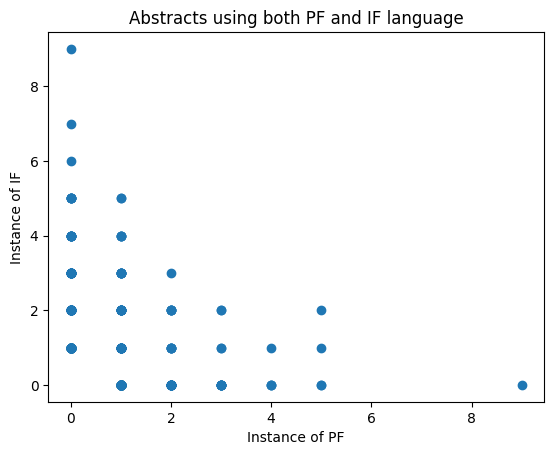

In [84]:
plt.scatter(title['Person-first'], title['Identity-first'])
plt.ylabel("Instance of IF")
plt.xlabel("Instance of PF")
plt.title("Abstracts using both PF and IF language")
plt.show()

#plt.savefig('..\\output\title_count.jpg')    # we can right click on the plot above to save it, or save it via command